# TF-IDF 행렬의 특이값 분해를 통한 LSA(Latent Semantic Analysis)의 구현과 빈도 기반 토픽 모델의 한계

## Step 1. 토픽모델링이란

토픽모델링은 특정 문서의 확률적 카테고리를 나누는 비지도학습 방법론이며 기본적인 컨셉은 다음과 같다. 
1. 문서는 단어의 조합이다.
2. 문서 내 함께 등장하는 단어는 서로 연관성이 있다.
3. 모든 문서에서 자주 등장하는 단어는 특수한 의미를 내포하지 않는다.
4. 반면, 그렇지 않은 단어는 특수한 의미를 내포한다.
5. 즉, 모든 문서에서 자주 등장하지 않으면서 특정 단어들과 함께 등장하는 단어들은 서로 유사한 의미를 내포한다.
6. 그러므로 단어의 조합인 문서는 의미가 있는 단어들의 비중에 따라 카테고리(Topic)가 결정된다.

우리는 이러한 컨셉의 프로세스에 따라 `1.문서를 단어 조합으로 가공`하고, `2~5.문서 내 각 단어들의  의미를 부여`한 다음, `6.문서의 토픽을 결정`해보도록 하자.

## Step 2. 분석 대상(문서) 확인

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text
import gensim
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.datasets as datasets

# MacOS - 한글 폰트
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# Graph Style
import mplcyberpunk
plt.style.use('cyberpunk')

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

분석 대상은 HuffPost의 뉴스데이터이며, 아래 캐글 링크에서 다운로드 받을 수 있다.
> https://www.kaggle.com/datasets/rmisra/news-category-dataset

In [2]:
df_all = pd.read_json('./datasets/news_category_dataset.json', lines=True)
df_all

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


데이터(뉴스 정보)는 총 20만개, 카테고리는 42개이며 그 중 Politics가 가장 많은 데이터를 차지한다.

In [3]:
len(df_all['category'].unique())

42

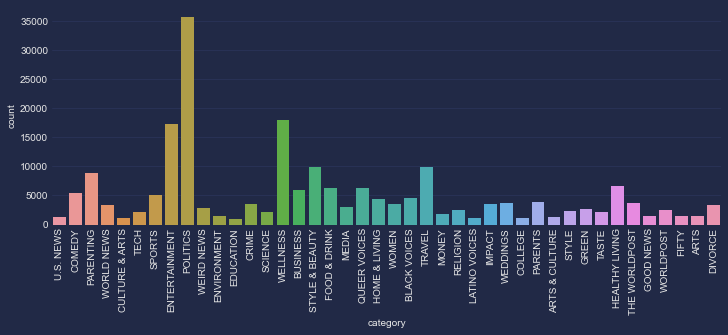

In [4]:
plt.figure(figsize=(12,4))
sns.countplot(df_all['category'])

plt.xticks(rotation=90)
plt.show()

우리는 이렇게 이미 잘 나눠진 카테고리를 다시 한번 토픽모델링을 통해 세부 카테고리로 나눠볼 것이다. 분석하고자 하는 뉴스 카테고리를 하나 선정한 다음 요약 내용을 담고 있는 short_description 부분만 추출한다. 

In [5]:
data = df_all[df_all['category']=='CRIME']['short_description']
data

107       Police in Tennessee say an arrest has been mad...
202       Allen Weisselberg is charged with taking more ...
241       Authorities say the search for a New Hampshire...
258       Authorities have said that all four of the kil...
269       Police are searching for the shooter, or shoot...
                                ...                        
207483    ABC News announced in July it had hired Smart ...
207545    20-year-old Hannah Kelley died Saturday mornin...
208133    The legislature also created the Timothy Cole ...
208134    I'm an advocate of gun control, and a knee-jer...
208213    Police have not yet released a cause of death ...
Name: short_description, Length: 3562, dtype: object

In [6]:
data.iloc[0] #sample 1  

'Police in Tennessee say an arrest has been made in the disappearance of a woman who was abducted while jogging.'

In [7]:
data.iloc[10] #sample 2

'The accused robber was struck multiple times, and two bystanders were wounded in the St. Louis shootout.'

빈 값이 있다면 지워주자.

In [8]:
data = data.replace('',np.nan).dropna()
data = data.reset_index(drop=True)
data

0       Police in Tennessee say an arrest has been mad...
1       Allen Weisselberg is charged with taking more ...
2       Authorities say the search for a New Hampshire...
3       Authorities have said that all four of the kil...
4       Police are searching for the shooter, or shoot...
                              ...                        
2827    ABC News announced in July it had hired Smart ...
2828    20-year-old Hannah Kelley died Saturday mornin...
2829    The legislature also created the Timothy Cole ...
2830    I'm an advocate of gun control, and a knee-jer...
2831    Police have not yet released a cause of death ...
Name: short_description, Length: 2832, dtype: object

## Step 3. 빈도 측면에서의 단어의 의미 부여(TF-IDF)

단어에 의미를 부여하는 방법은 다양하다. 어떤 방법이든 의미를 가지려면 단어를 숫자로 바꿔줘야 하며 이는 각 문서(short description)가 단어 벡터로 표현됨을 의미한다.  

변환 방법은 대표적으로 Bag of Words, Word Embedding 방식이 있으며 우리는 Bag of Words, 그 중에서도 TF-IDF(Term Frequency-Inverse Document Frequency) 방식을 사용한다. TF-IDF는 각 문장에서 출현하는 특정 단어 빈도인 TF(Term Frequency), 그리고 전체 문장에서 출현하는 특정 단어의 빈도인 IDF(Inverse Document Frequency)의 곱연산으로 정의되며, 이를 활용해 Step 1에서 소개한 토픽모델링 프로세스 중 2~5번 항목을 수행한다.

Word Embedding 방식이 각 단어별 잠재벡터(의미)를 즉시 부여한다면, TF-IDF는 단어의 출현 빈도와 비중을 토대로 문서의 잠재벡터를 추정한다. 따라서 엄밀히 말하면 TF-IDF는 각 단어가 그 자체로 의미를 지닐 수는 없으며 문장 내에서 혹은 토픽 내에서만 확률적으로 의미를 가진다.

### 3-1. TF

TF는 단순히 단어의 빈도를 의미한다. 따라서 CounterVectorizer() 함수 실행 결과값으로 함깨 확인할 수 있다.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
vectorizer = CountVectorizer(stop_words='english')
matrix = vectorizer.fit_transform(data)
matrix.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [11]:
tf = pd.DataFrame(
    data=matrix.todense(),
    columns=vectorizer.get_feature_names())

tf

,000,093,10,100,1000,10th,11,118,119,11th,...,zamora,zavala,zealand,zelich,zero,zimmerman,zoo,zumba,zuzanna,zuzu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


각 행(인덱스)은 문서를, 열(컬럼)은 단어를 의미한다. 각 데이터는 문서에 등장한 단어의 빈도가 되겠다.  
여기서 연산량을 줄이기 위해 데이터를 일부 제거할텐데, 단어를 너무 적게 가지고 있는 문서(행)와 전체 문서상에 너무 적게 등장하는 단어(열)는 삭제해주자. 물론, TF-IDF의 목적이 단어의 특수성과 보편성을 계산하기 위함인 것을 고려하면 원데이터로 분석하는 것이 가장 좋다.

- 단어를 너무 적게 가지고 있는 문서

In [12]:
tf.sum(axis=1).sort_values(ascending=True)

2042     0
844      0
1322     0
812      1
1167     1
        ..
2265    33
2263    33
2302    38
2300    53
2702    59
Length: 2832, dtype: int64

In [13]:
tf.sum(axis=1).describe()

count    2832.000000
mean        9.608757
std         4.723454
min         0.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        59.000000
dtype: float64

In [14]:
tf.sum(axis=1)

0        8
1       10
2       16
3        8
4       11
        ..
2827    13
2828    15
2829    12
2830    17
2831    10
Length: 2832, dtype: int64

In [15]:
tf.sum(axis=1).value_counts().index

Int64Index([ 9, 10, 11,  7, 12,  8,  6,  5, 13,  4, 14,  3, 15,  2, 16, 17, 18,
             1, 19, 21, 23, 20, 22, 26, 24, 27, 25, 29, 30,  0, 33, 32, 53, 38,
            59],
           dtype='int64')

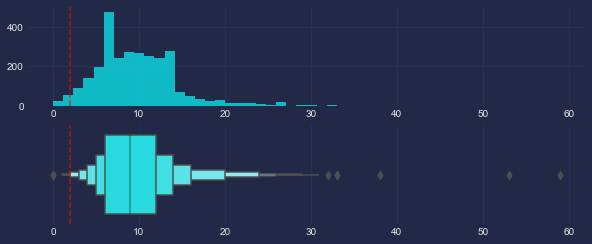

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,4))

axes[0].hist(tf.sum(axis=1), bins=50, alpha=0.7)
axes[0].axvline(x=2, c='r', linestyle='--', alpha=0.7)

sns.boxenplot(tf.sum(axis=1), ax=axes[1])
axes[1].axvline(x=2, c='r', linestyle='--', alpha=0.7)

plt.show()

문장의 길이가 긴 것은 정보를 많이 포함하므로 문제되지 않는다. 단어 2개 이하로 구성된 너무 짧은 문장은 삭제한다.

In [17]:
tf = tf[tf.sum(axis=1) > 2]
tf

,000,093,10,100,1000,10th,11,118,119,11th,...,zamora,zavala,zealand,zelich,zero,zimmerman,zoo,zumba,zuzanna,zuzu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- 전체 문서상에 너무 적게 등장하는 단어

In [18]:
tf.sum(axis=0).sort_values(ascending=True)

colorblind       0
outnumbered      0
butts            0
beef             0
outgunned        0
              ... 
people         172
old            208
year           234
said           350
police         389
Length: 7745, dtype: int64

In [19]:
tf.sum(axis=0).describe()

count    7745.000000
mean        3.497611
std        10.219430
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       389.000000
dtype: float64

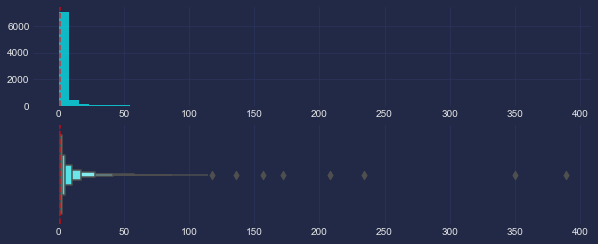

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,4))

axes[0].hist(tf.sum(axis=0), bins=50, alpha=0.7)
axes[0].axvline(x=1, c='r', linestyle='--', alpha=0.7)

sns.boxenplot(tf.sum(axis=0), ax=axes[1])
axes[1].axvline(x=1, c='r', linestyle='--', alpha=0.7)

plt.show()

잘 보이지 않으니 x축을 확대해서 살펴보자.

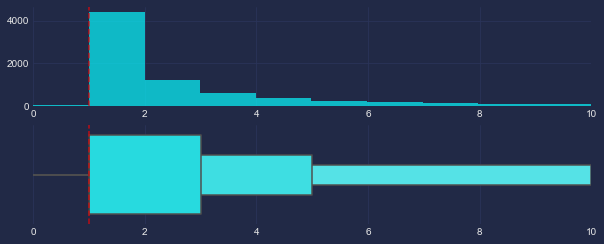

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,4))

axes[0].hist(tf.sum(axis=0), bins=390, alpha=0.7)
axes[0].axvline(x=1, c='r', linestyle='--', alpha=0.7)
axes[0].set_xlim(0,10)

sns.boxenplot(tf.sum(axis=0), ax=axes[1])
axes[1].axvline(x=1, c='r', linestyle='--', alpha=0.7)
axes[1].set_xlim(0,10)
plt.show()

문서 1개에만 존재하는 단어 비중이 매우 크기 때문에 제거하기 어렵다. 따라서 최소 1개 문서에는 출현하는 단어는 모두 단어 사전에 포함하는 것이 좋다.(단어는 사실 앞에서 너무 짧은 문장을 제거했을 때 발생된 데이터다. 따라서 이는 제거해주는 것이 맞다.) 그러나 실습의 편의를 위해 최소 2개의 문서에는 출현하는 단어만 단어 사전에 포함하도록 하자. 연산 속도를 높이기 위함이다.

In [23]:
tf = tf[tf.columns[tf.sum(axis=0) >= 2]]
tf

,000,10,100,10th,11,12,13,14,15,16,...,years,yes,york,young,younger,youth,zachary,zero,zimmerman,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


마지막으로 컬럼 중에 숫자로만 구성된 것들도 제거해주자.

In [24]:
import re

tf_alphacols = [x for x in tf.columns if len(re.findall(r'[^a-z]',x))==0] # 영어만 포함, 숫자 제외
len(tf_alphacols)

3211

In [25]:
tf = tf[tf_alphacols]
tf

,aaron,abandoned,abbott,abc,abdomen,abducted,abduction,abdul,abiding,abigail,...,years,yes,york,young,younger,youth,zachary,zero,zimmerman,zoo
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


이렇게 TF-IDF 중 TF(문서별 단어 빈도) 구성을 완료했다.

### 3-2. IDF

IDF는 DF의 inverse값이다. DF는 특정 단어가 출현하는 문서의 수를 의미한다. 따라서 전체 빈도의 합계와는 차이가 있다.

In [26]:
tf.sum().sort_values(ascending=False)

police     389
said       350
year       234
old        208
people     172
          ... 
jessica      2
jeff         2
jared        2
jan          2
zoo          2
Length: 3211, dtype: int64

In [27]:
(tf['police'] > 0).sum()

378

In [28]:
(tf['people'] > 0).sum()

167

이러한 특정 단어가 출현하는 문장의 수, 즉 DF의 역수를 취해주면 IDF가 되는데 이 때의 역수는 단순히 `1/DF`를 의미하는 것은 아니다.  
`총 문서의 수 + 1`를 `특정 단어를 포함하는 문서의 수 + 1`로 나누고 로그를 취한 다음 다시 1을 더해준다.  

이렇게 하는 이유는 다음과 같다. 
- 분자 혹은 분모가 0이 되지 않도록 총 문서의 수, 특정 단어를 포함하는 문서의 수에 각각 1을 더한다.
- 바로 위 셀에서 처럼 특정 단어를 포함하는 문서의 수가 총 문서의 수 대비 매우 작을 수 있다. 따라서 로그를 취해 분포가 너무 커지지 않도록 스케일을 줄여준다.
- 또 반대로 만약 대부분의 문서에 특정 단어가 포함되는 경우 자연로그를 취한 값은 0에 수렴할 것이다. IDF는 TF에 곱해지는 가중치로써 역할을 해줘야 하기 때문에 1을 더해준다. 

이렇게 해당 문서에 등장한 특정 단어가 희소할 경우 가중치를 크게, 빈번할 경우 가중치를 낮게 반영한다.


In [29]:
len(tf.values)

2758

In [30]:
D = len(tf)
idf = np.log((D+1) / (tf+1)) + 1
idf

,aaron,abandoned,abbott,abc,abdomen,abducted,abduction,abdul,abiding,abigail,...,years,yes,york,young,younger,youth,zachary,zero,zimmerman,zoo
0,8.922624,8.922624,8.922624,8.922624,8.922624,8.229476,8.922624,8.922624,8.922624,8.922624,...,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624
1,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,...,8.229476,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624
2,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,...,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624
3,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,...,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624
4,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,...,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,8.922624,8.922624,8.922624,8.229476,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,...,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624
2828,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,...,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624
2829,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,...,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624
2830,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,...,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624,8.922624


### 3-3. TF-IDF

앞에서 구한 tf와 idf를 곱해주면 TF-IDF가 된다. 즉, 각 문서별 특정 단어의 빈도가 TF인데 여기에 해당 단어가 얼마나 특수한가에 대한 정보(IDF)를 가중치로 곱해주는 것이다. 

In [31]:
tfidf = tf * idf 
tfidf

,aaron,abandoned,abbott,abc,abdomen,abducted,abduction,abdul,abiding,abigail,...,years,yes,york,young,younger,youth,zachary,zero,zimmerman,zoo
0,0.0,0.0,0.0,0.000000,0.0,8.229476,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,8.229476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,0.0,0.0,0.0,8.229476,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2828,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2829,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2830,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
tfidf.describe()

,aaron,abandoned,abbott,abc,abdomen,abducted,abduction,abdul,abiding,abigail,...,years,yes,york,young,younger,youth,zachary,zero,zimmerman,zoo
count,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,...,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000
mean,0.005968,0.008952,0.005968,0.017903,0.005968,0.008952,0.011935,0.005968,0.005968,0.005968,...,0.232447,0.022989,0.115488,0.059677,0.005968,0.020887,0.008952,0.005968,0.035218,0.005968
std,0.221570,0.271318,0.221570,0.383492,0.221570,0.271318,0.313234,0.221570,0.221570,0.221570,...,1.379008,0.561287,1.031372,0.698375,0.221570,0.414144,0.271318,0.221570,0.610658,0.221570
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.229476,8.229476,8.229476,8.229476,8.229476,8.229476,8.229476,8.229476,8.229476,8.229476,...,15.648023,15.648023,15.648023,8.229476,8.229476,8.229476,8.229476,8.229476,15.648023,8.229476


분포를 보면 대부분의 값이 0으로 최대값과 차이가 있다. 이는 너무 넓은 범위에 sparse한 데이터가 찍혀있는 것이므로 데이터를 한번 더 밀집 공간 내 압축해줄 필요가 있다.  
따라서 각 단어의 고유속성, 즉 단어 벡터크기(원점으로부터의 길이)를 나눠주자. 예를 들어 첫번째 단어의 경우 벡터크기는 다음과 같다. 

In [33]:
np.linalg.norm(tfidf.iloc[0])

21.773147957894007

이를 전체에 적용하여 모든 단어의 벡터 길이를 구하고, 이렇게 구한 벡터 길이로 단어별 빈도데이터를 나눠주면 분포는 다음과 같이 바뀐다.

In [34]:
norm_vec = np.linalg.norm(tfidf, axis=1, keepdims=True)
print('values: \n',norm_vec)
print('shape: \n',norm_vec.shape)

values: 
 [[21.77314796]
 [23.27647425]
 [31.87262502]
 ...
 [28.04736822]
 [30.36615596]
 [26.8128809 ]]
shape: 
 (2758, 1)


In [35]:
tfidf_norm = (tfidf / norm_vec)
tfidf_norm

,aaron,abandoned,abbott,abc,abdomen,abducted,abduction,abdul,abiding,abigail,...,years,yes,york,young,younger,youth,zachary,zero,zimmerman,zoo
0,0.0,0.0,0.0,0.000000,0.0,0.377964,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.353553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,0.0,0.0,0.0,0.301511,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2828,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2829,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2830,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
tfidf_norm.describe()

,aaron,abandoned,abbott,abc,abdomen,abducted,abduction,abdul,abiding,abigail,...,years,yes,york,young,younger,youth,zachary,zero,zimmerman,zoo
count,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,...,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000
mean,0.000286,0.000333,0.000214,0.000623,0.000265,0.000386,0.000469,0.000214,0.000188,0.000184,...,0.009975,0.000870,0.004180,0.002406,0.000216,0.000655,0.000377,0.000222,0.001334,0.000290
std,0.010992,0.010251,0.007947,0.013446,0.009853,0.011718,0.012432,0.008027,0.006994,0.006819,...,0.061071,0.021099,0.037211,0.028743,0.008010,0.013251,0.011686,0.008335,0.023064,0.010853
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.500000,0.353553,0.301511,0.333333,0.377964,0.377964,0.377964,0.333333,0.277350,0.258199,...,0.707107,0.625836,0.567383,0.500000,0.301511,0.377964,0.447214,0.353553,0.583601,0.447214


## Step 4. 토픽 추출

사실, 토픽모델링의 경우 LDA(Latent Dirichlet Allocation)가 대표적이지만 본 실습에서는 빈도 기반의 TF-IDF 행렬에서 어떻게 잠재의미를 추출해낼 수 있는가?를 분석해보기 위해 LSA(Latent Semantic Analysis) 방법론을 사용하고자 한다. 

LSA는 SVD 행렬분해(특이값 분해)를 통해 추출한 대각행렬(특이값 행렬)에서 정보량이 많은(값이 큰) 부분을 추출해 최소한의 차원(벡터)으로 토픽을 구성하는 방법론이다. 따라서 SVD를 1차 수행한 후 정보량이 많은 부분행렬을 추출하는 방식으로 LSA를 구현해보도록 하자.


먼저, SVD를 수행하기 전에 np.inf(무한대), 혹은 np.nan(계산불가)값이 있는지 확인해야 한다. 넘파이 연산시 실수를 0으로 나누면 inf 값을, 0을 0으로 나누면 NaN값을 반환하게 되는데, 앞서 충분히 많은 0의 극한 값들을 서로 연산했기 때문에 문제 가능성이 있다.

In [37]:
(tfidf_norm==np.inf).sum().sum()

0

In [38]:
tfidf_norm.isna().sum()

aaron        0
abandoned    0
abbott       0
abc          0
abdomen      0
            ..
youth        0
zachary      0
zero         0
zimmerman    0
zoo          0
Length: 3211, dtype: int64

NaN값들이 확인되었다. 해당 행을 제거한다.

In [39]:
tfidf_norm = tfidf_norm.dropna()
tfidf_norm

,aaron,abandoned,abbott,abc,abdomen,abducted,abduction,abdul,abiding,abigail,...,years,yes,york,young,younger,youth,zachary,zero,zimmerman,zoo
0,0.0,0.0,0.0,0.000000,0.0,0.377964,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.353553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,0.0,0.0,0.0,0.301511,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2828,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2829,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2830,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4-1. SVD

SVD(Singular Value Decomposition)는 A=(M x N) 행렬을 U=(M x M), S=(M x N), VT=(N x N) 3개의 행렬로 분해한다.  
여기서 U는 직교행렬, VT 직교행렬을 transpose시킨 전치행렬, S는 직사각 대각행렬이다. 이 때, A=U\*S\*VT에서 양 변에 V를 곱하면 A*V=U*S가 된다. 이 식의 의미는 직교행렬 V를 A행렬로 선형변환했을 때, 각도는 동일하고 길이만 다른 직교행렬 U*S가 된다는 것이다. 이러한 작용의 의미, 혹은 과정이나 맥락을 이해하기 위해서는 먼저 선형대수의 관점에서 직교행렬 및 단위행렬의 성질을 이해할 필요가 있다. 그러나 우리는 결과적으로 이 식을 구함으로써 어떤 이점이 있는가에 초점을 맞추도록 하자.  

A=U*S*VT의 식으로 다시 돌아와보면, S가 어떤 값을 가지든 U의 행(M)과 VT의 열(N)이 A의 그것(M x N)과 동일해야 함을 알 수 있다. 만약 S=(1 x 1)이라면, U=(M x 1), VT=(1 x N)이 되어야 하고, S=(2 x 100)이라면, U=(M x 2), VT=(100 x N)이 되어야 한다. 여기서 불변하는 것은 M과 N이다. 그리고 A가 (문서 x 단어)의 행렬이므로 M=문서, N=단어가 된다. 문서는 단어벡터로 이루어져 있었다. 즉, `단어->문서`로 즉시 이어지던 관계를 `단어->[잠재벡터]->문서`로 한 단계를 더 넣은 것으로 이해해볼 수 있다. 이 잠재벡터가 바로 토픽이며, 단어 조합을 문장으로 만들어주는 어떠한 정보를 내포하는 것이다.  

결과적으로 S는 토픽 정보를 가지고 있는데 그 크기는 (1 x 1) 부터 (M x N)까지의 자유도를 가진다. 이 때, 자연스럽게도 S가 (1 x 1)일 때나 (M x N)일 때나 모두 U\*S\*VT는 A의 형태는 갖춰야 하기 때문에 S가 아무리 작아도(S=(1 x 1)) 최소한의 정보는 가지고 있을 것이라 생각해볼 수 있다. 실제로 S의 대각 원소의 값은 좌상단부터 우하단까지 내려갈수록 작아진다. 즉, S의 대각 원소 첫번째 값이 가장 중요한 정보를 가지고 있고, 가장 마지막 값이 가장 작은 정보를 가지는 것이다. 따라서 **우리는 SVD를 수행해 S를 구함으로써 A가 구성되기 위해 가장 중요한 정보부터 가장 중요하지 않은 정보까지의 값을 확인할 수 있게 되는 것**이다. 
  
SVD는 넘파이 선형대수 패키지를 통해 간단히 수행할 수 있다.

In [40]:
U, s, VT = np.linalg.svd(tfidf_norm.to_numpy(), full_matrices=True)

U = np.round(U, 10) # Matrix
s = np.round(s, 10) # Vector
VT = np.round(VT, 10) # Matrix
print('U: ',U.shape)
print('S: ',s.shape)
print('transposed V: ', VT.shape)

U:  (2758, 2758)
S:  (2758,)
transposed V:  (3211, 3211)


### 4-1. S

잠재벡터 s를 먼저 확인해보자. svd()함수를 사용하면 s는 벡터로 추출된다. 이 벡터의 첫번째 값이 가장 크고, 마지막 값으로 갈수록 가장 작아지는 것을 확인할 수 있다. 이것이 각 토픽의 정보량이 된다.

In [44]:
print('top 10: \n', s[:10])
print('bottom 10: \n',s[-10:])

top 10: 
 [8.50535997 6.9763459  6.38926114 5.03842837 4.53208808 4.34933217
 4.21005095 4.03818362 3.91605753 3.81528791]
bottom 10: 
 [0.01749017 0.01682185 0.01465156 0.0124834  0.01133178 0.00982535
 0.00925724 0.00902188 0.         0.        ]


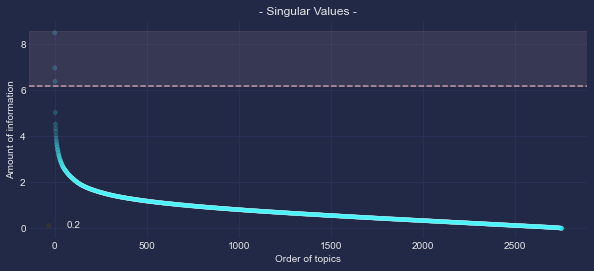

In [55]:
s_y = s.tolist()
s_x = np.arange(len(s))

n_dim = 3
plt.figure(figsize=(10,4))
sns.scatterplot(x=s_x, y=s_y, size=0.2, alpha=0.2)
plt.axhline(y=s[n_dim-1]-0.2, c='pink', linestyle='--', alpha=0.7)
plt.axhspan(ymax=s[0]*1.01, ymin=s[n_dim-1]-0.2, color='pink',alpha=0.1)

plt.xlabel('Order of topics')
plt.ylabel('Amount of information')
plt.title('- Singular Values -')

plt.show()

차트에서 붉은 영역에 속한 점들이 가장 설명력이 높은 상위 3개 토픽을 표시하고 있다. 이 3개 토픽만 활용해 문서의 주제를 분석한다.  
참고로 잠재벡터를 다음과 같이 대각행렬로 표현해줄 수도 있다.

In [57]:
S = np.diag(s[:n_dim])

print('S: \n',S)
print('Shape: \n',S.shape)

S: 
 [[8.50535997 0.         0.        ]
 [0.         6.9763459  0.        ]
 [0.         0.         6.38926114]]
Shape: 
 (3, 3)


In [58]:
topics = [f'topic_{x}' for x in range(1,n_dim+1)]

In [59]:
topics

['topic_1', 'topic_2', 'topic_3']

In [60]:
df_S = pd.DataFrame(data=S, 
                    columns=topics, 
                    index=topics)
df_S

,topic_1,topic_2,topic_3
topic_1,8.50536,0.000000,0.000000
topic_2,0.00000,6.976346,0.000000
topic_3,0.00000,0.000000,6.389261


### 4-2. U

U는 문서가 전체 토픽마다 일치하는 확률을 담고 있다. 특이값 s의 크기 3에 맞춰 열을 잘라주면 가장 설명력(정보량)이 높은 3개 토픽에 대한 확률만 추출된다.

In [61]:
U

array([[-3.85563224e-02, -3.92387770e-03,  4.85638146e-02, ...,
         4.19391300e-04,  0.00000000e+00,  0.00000000e+00],
       [-3.15023240e-03,  3.39816190e-03, -1.68221440e-03, ...,
        -1.26068300e-04, -0.00000000e+00, -0.00000000e+00],
       [-1.95336483e-02,  2.58419185e-02, -1.88325880e-03, ...,
        -6.36287470e-03,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-6.47811400e-04,  9.26995000e-05,  1.79111500e-04, ...,
         1.75560000e-04, -0.00000000e+00,  0.00000000e+00],
       [-3.11825600e-03,  2.11661110e-03, -5.93016800e-04, ...,
        -8.77192900e-04,  0.00000000e+00,  0.00000000e+00],
       [-2.82280047e-02, -4.35432210e-03,  3.23568472e-02, ...,
        -8.21482740e-03, -0.00000000e+00,  0.00000000e+00]])

U를 데이터프레임으로 변환해줄텐데, index를 기존 문서 인덱스에 맞게 지정해주는 것이 중요하다.

In [100]:
df_U = pd.DataFrame(data=U[:,:n_dim],
                    columns=topics,
                    index=tfidf_norm.index)
df_U

,topic_1,topic_2,topic_3
0,-0.038556,-0.003924,0.048564
1,-0.003150,0.003398,-0.001682
2,-0.019534,0.025842,-0.001883
3,-0.026798,-0.025297,-0.040269
4,-0.026501,-0.005274,0.031754
...,...,...,...
2827,-0.001176,0.000883,0.000646
2828,-0.024128,0.051965,-0.013522
2829,-0.000648,0.000093,0.000179
2830,-0.003118,0.002117,-0.000593


In [101]:
df_U.describe()

,topic_1,topic_2,topic_3
count,2758.000000,2758.000000,2758.000000
mean,-0.012358,0.001532,-0.000721
std,0.014489,0.018983,0.019031
min,-0.076874,-0.048845,-0.074088
25%,-0.022810,-0.000867,-0.001879
50%,-0.005046,0.000331,-0.000203
75%,-0.002355,0.001931,0.001809
max,-0.000017,0.101591,0.077830


아래에서 시각화를 해줄텐데, X, Y, Z 좌표 범위를 0~1로 동일하게 맞추기 위해 스케일링을 미리 수행해주겠다.

In [102]:
df_U_scaled = df_U - df_U.min()
df_U_scaled /= (df_U.max() - df_U.min())
df_U_scaled.describe()

,topic_1,topic_2,topic_3
count,2758.000000,2758.000000,2758.000000
mean,0.839432,0.334870,0.482939
std,0.188523,0.126189,0.125274
min,0.000000,0.000000,0.000000
25%,0.703442,0.318925,0.475319
50%,0.934573,0.326889,0.486349
75%,0.969584,0.337523,0.499589
max,1.000000,1.000000,1.000000


### 4-3. V

마지막으로 V는 각 단어가 각각의 토픽마다 일치하는 확률을 담고 있다. VT를 특이값 s의 크기 3에 맞춰 행을 잘라주면 가장 설명력(정보량)이 높은 3개 토픽에 대한 확률만 추출되고 이를 Transpose 시키면 V를 구할 수 있다.

In [65]:
words = tfidf_norm.columns
words[:5] #samples

Index(['aaron', 'abandoned', 'abbott', 'abc', 'abdomen'], dtype='object')

In [66]:
df_V = pd.DataFrame(data=VT[:n_dim,:],
                     columns=words,
                     index=topics).T # transpose
df_V

,topic_1,topic_2,topic_3
aaron,-0.001877,0.005401,-0.001871
abandoned,-0.001054,0.002966,-0.001049
abbott,-0.000972,-0.000026,0.001300
abc,-0.001969,0.002147,0.000277
abdomen,-0.001380,-0.001348,-0.002127
...,...,...,...
youth,-0.001557,0.002815,-0.000820
zachary,-0.003166,-0.000821,0.005203
zero,-0.000107,0.000027,-0.000050
zimmerman,-0.002915,-0.001105,0.000040


In [67]:
df_V.describe()

,topic_1,topic_2,topic_3
count,3211.000000,3211.000000,3211.000000
mean,-0.003499,0.000648,-0.000197
std,0.017300,0.017638,0.017649
min,-0.626119,-0.471813,-0.654276
25%,-0.002824,-0.000592,-0.001151
50%,-0.001319,0.000045,-0.000026
75%,-0.000438,0.000535,0.000711
max,-0.000002,0.621317,0.623630


V도 마찬가지로 시각화를 위해 스케일링을 진행하자.

In [68]:
df_V_scaled = df_V - df_V.min()
df_V_scaled /= (df_V.max() - df_V.min())
df_V_scaled.describe()

,topic_1,topic_2,topic_3
count,3211.000000,3211.000000,3211.000000
mean,0.994415,0.432209,0.511837
std,0.027630,0.016136,0.013811
min,0.000000,0.000000,0.000000
25%,0.995494,0.431075,0.511090
50%,0.997897,0.431657,0.511971
75%,0.999303,0.432106,0.512547
max,1.000000,1.000000,1.000000


In [69]:
df_V_scaled

,topic_1,topic_2,topic_3
aaron,0.997005,0.436557,0.510526
abandoned,0.998319,0.434330,0.511170
abbott,0.998452,0.431593,0.513008
abc,0.996858,0.433580,0.512207
abdomen,0.997799,0.430383,0.510326
...,...,...,...
youth,0.997517,0.434192,0.511349
zachary,0.994946,0.430865,0.516063
zero,0.999833,0.431642,0.511952
zimmerman,0.995348,0.430606,0.512022


### 4-4. 각 토픽에 해당하는 확률 시각화

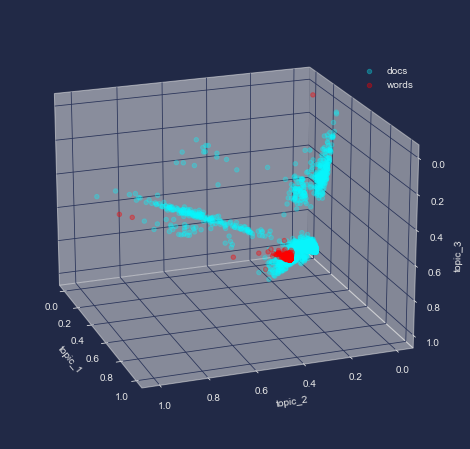

In [103]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

# U (docs)
xs, ys, zs = (df_U_scaled['topic_1'].values, 
              df_U_scaled['topic_2'].values, 
              df_U_scaled['topic_3'].values)
ax.scatter(xs, ys, zs, alpha=0.3, label='docs')

# V (words)
xs, ys, zs = (df_V_scaled['topic_1'].values, 
              df_V_scaled['topic_2'].values, 
              df_V_scaled['topic_3'].values)
ax.scatter(xs, ys, zs, alpha=0.35, c='r', label='words')


ax.view_init(200, 200)

ax.set_xlabel('topic_1')
ax.set_ylabel('topic_2')
ax.set_zlabel('topic_3')

plt.legend(loc=(0.8,0.8))
plt.show()

docs는 펼쳐져있는 반면, words는 상대적으로 공간상 수렴해있다. 이 현상을 잠시 짚어보자.  

Step 1로 돌아가서, 문서는 단어의 조합이라 했다. 각 단어는 동시 출현 빈도에 따라 연관성을 가지며 이러한 연관성이 결과적으로 토픽을 결정한다. 이렇게 결정된 토픽에 단어 조합으로 구성된 각 문서가 일치할 확률을 표현한다. 따라서 U와 V는 모두 토픽에 일치할 확률을 보여주지만 개념적으로 단어가 토픽의 정보량을 결정하고 그렇게 결정된 정보로 문서를 설명하기 때문에 words 대비 docs는 분포가 펼쳐질 수 밖에 없다는 것이다.  


## Step 5. 토픽모델링 결과 분석

토픽모델링의 결과는 각 토픽별 단어의 확률분포, 문서의 확률분포가 되겠다. 즉, 특정 단어가 topic 1, 2, 3 각각에 해당할 확률이 얼마인지, 또 특정 문서가 topic 1, 2, 3 각각에 해당하는 확률이 얼마인지 확인할 수 있다. 우리가 앞서 뉴스 카테고리 1개를 선정 후, 카테고리 내 세부카테고리를 더 나눌 수 있는가?에 관심을 가졌으며 토픽모델링 결과에 따라 그것의 여부를 확인하게 된다.

### 5-1. 각 토픽별 단어 분포

In [123]:
top_words_t1 = df_V_scaled['topic_1'].sort_values(ascending=False)[:20]
top_words_t1

gauchistes     1.000000
mais           1.000000
islamistes     1.000000
il             1.000000
sont           1.000000
monde          1.000000
golden         0.999992
binary         0.999967
indoors        0.999960
advisory       0.999953
uncertain      0.999952
historic       0.999944
wagner         0.999943
options        0.999935
sought         0.999934
created        0.999931
parallel       0.999929
sit            0.999929
sales          0.999927
territories    0.999924
Name: topic_1, dtype: float64

topic_1은 주로 무슬림계 범죄, 급진주의 테러리즘에 대한 내용으로 보인다. gauchistes(좌파), mais(이슬람 종교 협의회), islamistes(이슬람) 같은 단어들이 상단에 등장하고 있다.

In [105]:
top_words_t2 = df_V_scaled['topic_2'].sort_values(ascending=False)[:20]
top_words_t2

year         1.000000
old          0.956061
allegedly    0.493386
man          0.490470
woman        0.475657
accused      0.473427
girl         0.469901
arrested     0.467038
years        0.464333
murder       0.459656
charged      0.459521
boy          0.457574
killing      0.453978
new          0.453639
home         0.453009
death        0.451652
custody      0.451034
face         0.450359
son          0.449003
convicted    0.448017
Name: topic_2, dtype: float64

topic_2의 경우 남, 여, 아동 등 일반 시민 대상의 살인 범죄에 대한 내용으로 보이며 최상단에 year이라는 단어가 등장함으로 추측컨데 연간 범죄율 등이 주축을 이룰 것이다.

In [106]:
top_words_t3 = df_V_scaled['topic_3'].sort_values(ascending=False)[:20]
top_words_t3

police        1.000000
say           0.686741
shot          0.567750
suspect       0.562387
man           0.559339
people        0.551976
killed        0.549820
officer       0.540525
officers      0.532042
fatally       0.531083
believe       0.529956
death         0.529131
told          0.528749
says          0.527719
city          0.526300
ap            0.525853
searching     0.525114
area          0.524875
department    0.524848
chief         0.524401
Name: topic_3, dtype: float64

마지막으로 topic_3의 경우 police, officer, say 등이 상단에 위치한 것으로 보아 경찰의 행동이나 발언에 초점을 맞추고 있음을 알 수 있다. 

종합적으로 topic_1는 테러 같은 국가적 이슈, topic_2는 소규모 범죄 피해, topic_3은 치안 및 관련 보도를 다루고 있으며, topic_1에 비해 topic_2와 topic_3은 그 성향이 상대적으로 뚜렷하지는 않다. 각 토픽에 대해 단어별 확률 분포를 시각적으로 확인해보자.

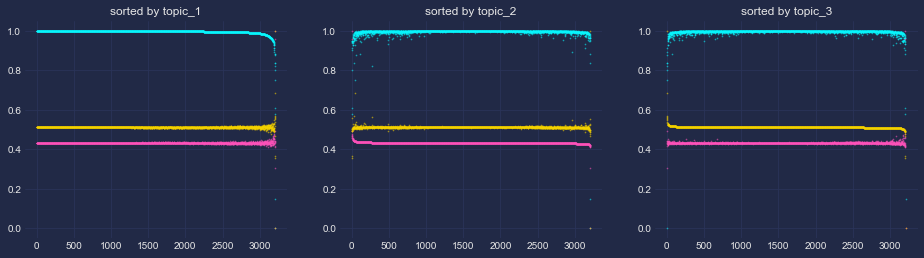

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

d1_sorted = df_V_scaled.sort_values(by='topic_1',ascending=False)
d2_sorted = df_V_scaled.sort_values(by='topic_2',ascending=False)
d3_sorted = df_V_scaled.sort_values(by='topic_3',ascending=False)

for i, d_sorted in enumerate([d1_sorted, d2_sorted, d3_sorted]):
    axes[i].scatter(x=np.arange(0, len(d_sorted)), y=d_sorted['topic_1'].values, s=0.5, alpha=0.5)
    axes[i].scatter(x=np.arange(0, len(d_sorted)), y=d_sorted['topic_2'].values, s=0.5, alpha=0.5)
    axes[i].scatter(x=np.arange(0, len(d_sorted)), y=d_sorted['topic_3'].values, s=0.5, alpha=0.5)
    axes[i].set_title(f'sorted by topic_{i+1}')

plt.show()

topic_1의 경우 각 단어의 확률값이 전체적으로 매우 높은 반면, topic_2와 topic_3은 0.5 근처로 낮다. 이는 추출된 특이값 중 가장 앞에 위치해있던 topic_1의 정보량이 가장 많기 때문이다. 

한편으로는 토픽모델링을 수행했을 때 이렇게 모든 단어의 topic_1, topic_2, topic_3에 대한 각 확률값이 유사한 경우 제대로된 분석 결과가 나오지 않는데, 이는 빈도기반 토픽모델링의 근본적 한계이기도 하다. 마지막 결론에서 이 내용에 대해 다시 언급하겠다.

### 5-2. 각 토픽별 문서 분포

다음으로 각 토픽과 가장 일치할 확률이 높은 문서도 확인해볼 수 있다. 

In [125]:
top_docs_t1 = df_U_scaled['topic_1'].sort_values(ascending=False)[:5]
top_docs_t1

2021    1.000000
454     0.999887
517     0.999879
2087    0.999825
984     0.999808
Name: topic_1, dtype: float64

In [132]:
data.loc[top_docs_t1.index].values

array(['He shipped some of it to the islands hidden with a Golden Nugget sweater.',
       '“It’s outrageous, unacceptable, incredibly unprofessional, and cannot be tolerated.”',
       'She was covering a shift for another coworker.',
       '"We go up and we sit in Alex\'s row ... and we sit next to him."',
       'Bag containing explosive devices was found in a wastebasket.'],
      dtype=object)

앞서 확인했을 때 topic_1은 테러와 같은 극단적인 범죄에 대한 토픽이었다. 위 문장 중 1번째는 밀수, 5번째는 폭탄테러에 대한 내용이며 나머지는 topic_1과 그다지 근접해보이지는 않는다.  
이러한 문서들도 포함된 이유는 topic_1과 일치할 단어의 확률 분포가 매우 높기 때문인데, 그러한 단어들이 문장에 조금만 들어가더라도 문장 자체의 토픽 일치 확률이 크게 상승하게 된다. 따라서 topic_1의 경우 확률 분포상 상위에 있는 문서들이 아이러니하게도 topic_1과 맥락상 유사하지 않을 가능성도 높은 것이다.

In [135]:
top_docs_t2 = df_U_scaled['topic_2'].sort_values(ascending=False)[:5]
top_docs_t2

1699    1.000000
2343    0.992074
1404    0.946971
2084    0.917597
728     0.914366
Name: topic_2, dtype: float64

In [136]:
data.loc[top_docs_t2.index].values

array(['A 36-year-old mother. A 29-year-old Iraq vet. A 44-year-old police officer.',
       'In August of last year, 31-year-old Emily Creno allegedly told her 4-year-old son he was going to die, and subjected him',
       'The 18-year-old is accused of defrauding an 86-year-old woman who he "treated" for stomach pain.',
       'A 25-year-old Florida woman was charged with murder after allegedly killing her father and 6-year-old daughter and then using',
       'A 12-year-old girl was among the victims.'], dtype=object)

topic_2의 경우 상위 문서은 예상과 동일하게 일상에서 발생가능한 살인 범죄 등의 사건을 다루고 있다.

In [137]:
top_docs_t3 = df_U_scaled['topic_3'].sort_values(ascending=False)[:5]
top_docs_t3

1418    1.000000
1205    0.994324
2258    0.985091
1110    0.931247
250     0.930977
Name: topic_3, dtype: float64

In [138]:
data.loc[top_docs_t3.index].values

array(['Police say he fled with around $2,000.',
       'Police say the man was involved in a domestic dispute and rushed the police officer.',
       'As the police profession and our greater society deal with ways to rebuild (and in many cases build) relationships between the police and its citizenry, I fear that if outsider reformers call for police to ignore disorderly offenses the chasm between the police and the community will only widen.',
       "Kamayi Matumona's upbeat mood didn't last for long, say police.",
       '"There was no package explosion," police say.'], dtype=object)

topic_3도 역시 마찬가지로 앞서 토픽에 대해 정의한 것처럼 경찰의 발언 및 보도에 관한 내용을 담고 있다.

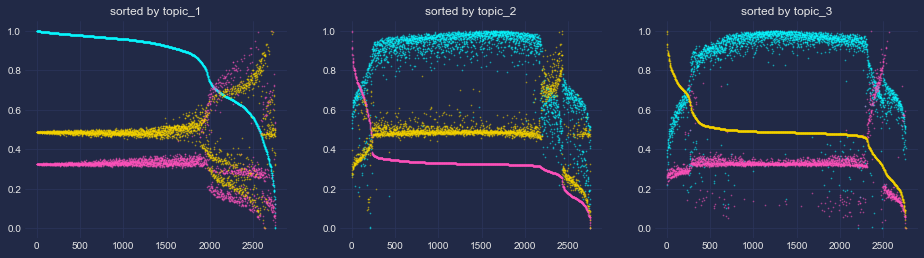

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

d1_sorted = df_U_scaled.sort_values(by='topic_1',ascending=False)
d2_sorted = df_U_scaled.sort_values(by='topic_2',ascending=False)
d3_sorted = df_U_scaled.sort_values(by='topic_3',ascending=False)

for i, d_sorted in enumerate([d1_sorted, d2_sorted, d3_sorted]):
    axes[i].scatter(x=np.arange(0, len(d_sorted)), y=d_sorted['topic_1'].values, s=0.5, alpha=0.5)
    axes[i].scatter(x=np.arange(0, len(d_sorted)), y=d_sorted['topic_2'].values, s=0.5, alpha=0.5)
    axes[i].scatter(x=np.arange(0, len(d_sorted)), y=d_sorted['topic_3'].values, s=0.5, alpha=0.5)
    axes[i].set_title(f'sorted by topic_{i+1}')

plt.show()

토픽별로 각각의 문서가 속할 확률을 보여주고 있으며 왼쪽부터 순서대로 topic_1, topic_2, topic_3을 기준으로 확률분포를 정렬시켰다.  
문서의 기준으로 보면, 각 문서는 모두 3개 토픽에 포함될 확률을 각각 가지고 있는데, 약 2천개의 문서는 모두 topic_1에 포함될 확률이 가장 높다.(가장 왼쪽 차트)  

이는 앞에서도 확인했지만 topic_1과 일치하는 단어가 뚜렷한(확률이 큰) 만큼 그 단어가 속한 문서도 topic_1에 속할 확률이 높아지는 것에 원인이 있다.

### 5-3. 각 토픽별 주요 문서의 단어 분포

마지막으로 각 토픽별로 일치 확률이 가장 높은 문서들에 어떤 단어들이 포함되어 있는지 확인해본다. 이 때, 단어 역시 각 토픽별 가장 높은 확률을 가진 단어들로 구성하여 동일한 단어들이 문서별로 또 어떻게 다르게 분포되어 있는가를 확인하고자 한다.

In [112]:
def show_word_values(topic_i, doc_n, word_n):
    docs = df_U_scaled[f'topic_{topic_i}'].sort_values(ascending=False)[:doc_n]
    words = df_V_scaled[f'topic_{topic_i}'].sort_values(ascending=False)[:word_n]
    
    rows = docs.index
    cols = words.index


    data = tfidf_norm.loc[rows, cols]

    fig, axes = plt.subplots(nrows=doc_n, ncols=1, figsize=(17,8))
    for i, data in enumerate(data.iterrows()):
        x = data[1].index
        y = data[1].values
        axes[i].bar(x=x, height=y)
        axes[i].set_title(data[0])
        
    plt.tight_layout()
    plt.show()

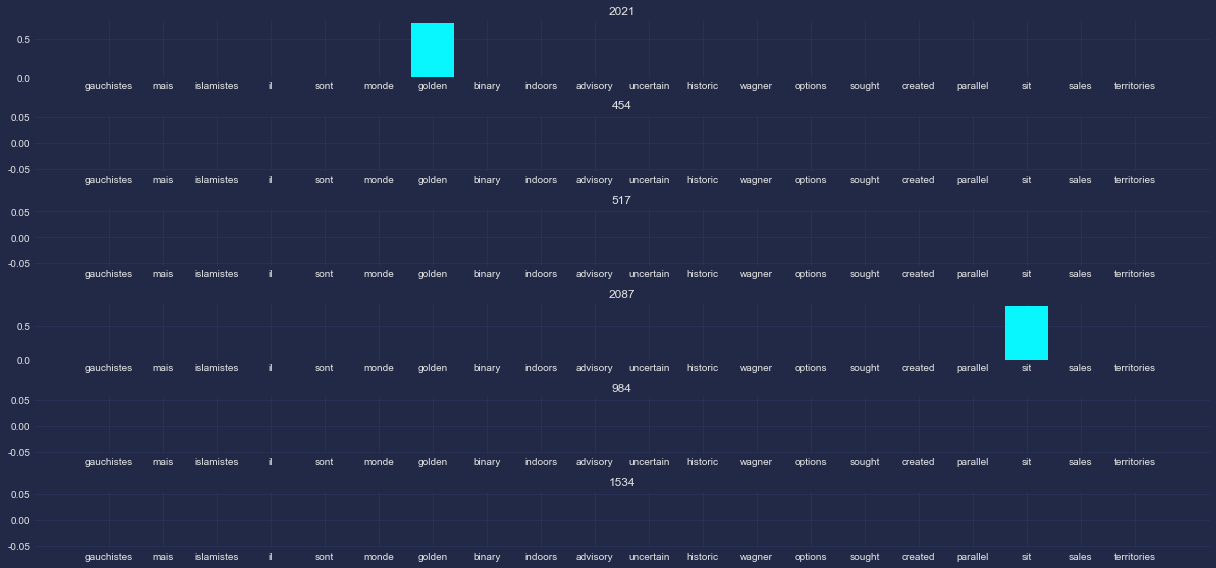

In [113]:
show_word_values(topic_i=1, doc_n=6, word_n=20)

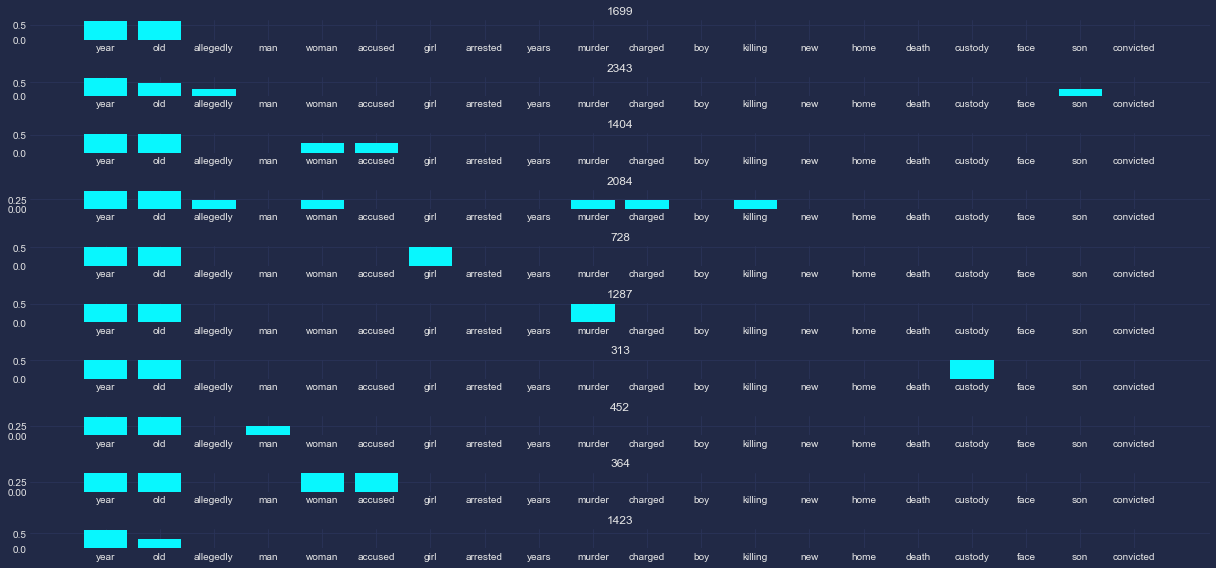

In [114]:
show_word_values(topic_i=2, doc_n=10, word_n=20)

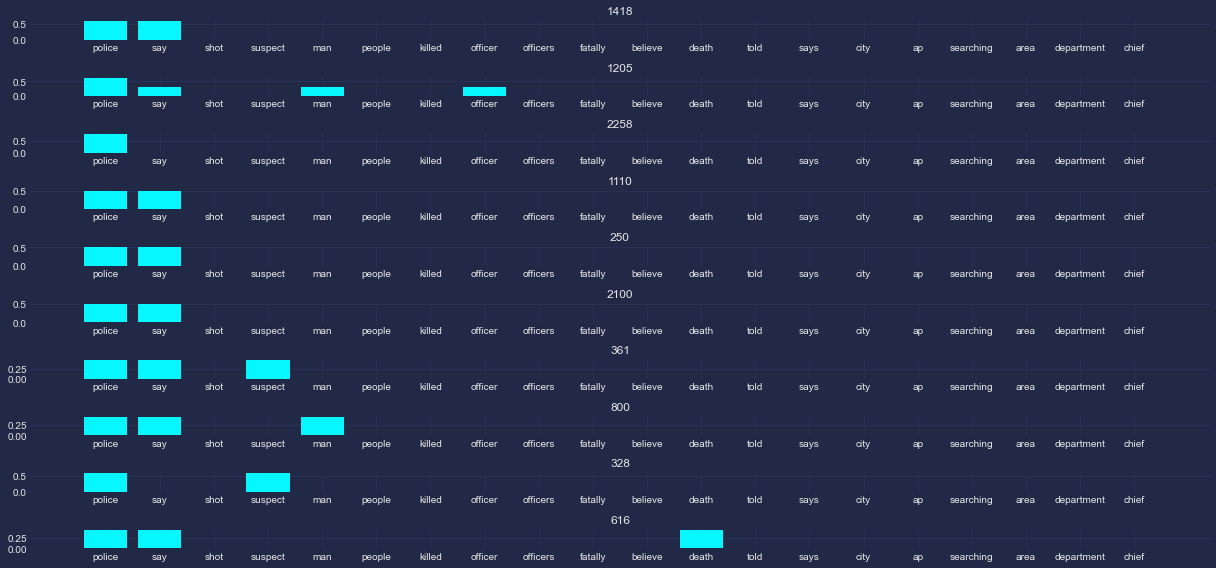

In [115]:
show_word_values(topic_i=3, doc_n=10, word_n=20)

topic_2와 topic_3의 경우 각각의 문서가 토픽에 대한 확률값이 높은 단어들 위주로 잘 포함하고 있는 반면 topic_1은 그렇지 않다. 모든 단어들이 topic_1에 포함될 확률이 1에 근사하기 때문이다.

이렇게 문서별 단어 분포까지 확인해보았다. 빈도기반 토픽모델링 LSA는 문장 내 단어의 동시 출현 빈도 및 특수성 가중치를 고려한 TF-IDF 행렬에 대해 특이값을 추출하는 방식으로 발전시켜 단어의 잠재 의미를 끌어내고자 시도했다는 점에서 의의가 있었다. 하지만 이 방법론의 결과로, 토픽 내부적으로는 연관관계가 높은 단어들이 서로 밀집할 수 있었으나 단어의 의미를 고려할 수 없다는 점에서 한계 또한 분명했다.   

사실, 본 분석에서는 연산 속도 제약상 단어 집합이 정규분포를 따라야 한다는 LSA의 중요한 기본 가정을 무시하고 편향이 있는 단어 분포를 사용했다. 그러나 이를 차치하더라도 LSA는 그 원리상 빈도 기반 연관성만 고려하지 각 단어별 잠재된 의미를 고려하지는 않기 때문에 단어별로 각 토픽에 속할 확률이 큰 폭에서 차이가 없을 가능성이 매우 높으며, 분석에서는 그 특성을 다소 극대화해보였다. 이러한 한계가 문서의 주제 분류에 있어서 현실적인 사용에 많은 제약을 주게 된다.
